# An simple example of how to calculate averaged PSD with stingray

[Stingray](https://stingray.readthedocs.io/en/latest/stingray/docs/api.html) is a package for timing analysis of astronomical X-ray data. This doc introduce how to calculate the averaged PSD from a light curve.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum

from IPython.display import set_matplotlib_formats

import stingray_supp as supp

%matplotlib inline
set_matplotlib_formats('svg')

## Define the `LightCurve` class

It's necessary to define the time series, count rate, error bars and GTIs to creat a lightcurve object. We first open the light curve file with astropy and then extract those necessay infomation.

### Open the light curve file

In [2]:
infile='LE_net_1_10.lc'
# bin time: 0.01s

In [3]:
hdul = fits.open(infile)

In [4]:
hdul[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'RATE'; format = 'E'; unit = 'count/s'
    name = 'ERROR'; format = 'E'; unit = 'count/s'
    name = 'FRACEXP'; format = 'E'
)

### Creat `LightCurve` object

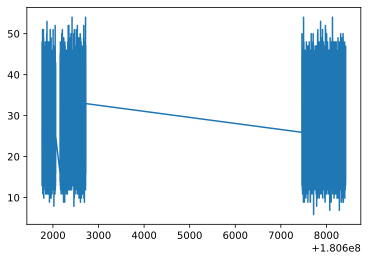

In [10]:
time = hdul[1].data['TIME']
rate = hdul[1].data['rate']
error = hdul[1].data['ERROR']

# To get GTIs from the light curve file
gti_row = hdul[2].data
gti = np.empty(shape=(len(gti_row['START']),2))
for i in range(len(gti_row['START'])):
    gti[i,0] = gti_row['START'][i]
    gti[i,1] = gti_row['STOP'][i]

lc = Lightcurve(time=time, counts=rate, err=error, input_counts=False, gti=gti)
# input_counts=False means we are using counts/sec as unit

lc.plot()

In [56]:
# Check the GTIs
lc.gti

array([[1.80601761e+08, 1.80602061e+08],
       [1.80602156e+08, 1.80602721e+08],
       [1.80607461e+08, 1.80608421e+08]])

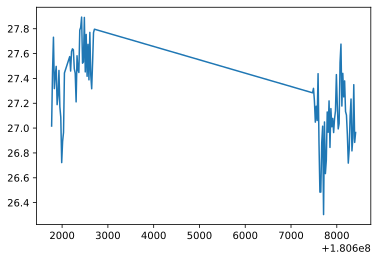

In [11]:
# rebin the light curve if you want

lc_rebinned = lc.rebin(20, method='average')
lc_rebinned.plot()

## Calculate the averaged PSD

It's super easy to get the averaged PSD using stingray once the `LightCurve` object is well defined. The segment size and normaliztion method have to be provided though.

In [13]:
avepsd=AveragedPowerspectrum(lc=lc, segment_size=50, norm='frac')

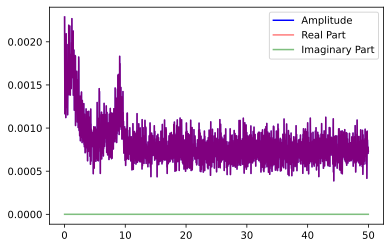

In [14]:
avepsd.plot()

In [18]:
# Some info about the PSD

avepsd.freq.shape, avepsd.power.shape,

((2499,), (2499,))

In [20]:
white_noise = np.mean(avepsd.power[1500:2400])

### Plot using your own style

In this example, the PSD is not rebinned, but rebinning can be done in stingray.

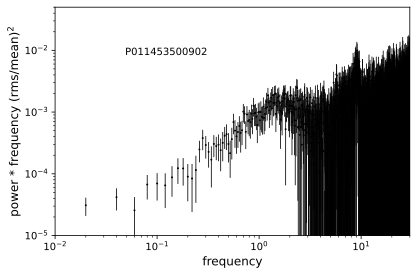

In [23]:
fig = plt.figure(figsize=(6,4))
plt.errorbar(x=avepsd.freq, y=(avepsd.power-white_noise)*avepsd.freq, xerr=0.0, yerr=avepsd.power_err*avepsd.freq, 
             fmt='o', lw=0.8, ms=1, color='black')

plt.xscale('log')
plt.yscale('log')


plt.xlim(0.01,30)
plt.ylim(1e-5, 0.05)

plt.xlabel('frequency', fontsize=12)
plt.ylabel(r'power * frequency (rms/mean)$^2$', fontsize=12)

plt.annotate('P011453500902', xy=(0.3,0.8), xycoords='figure fraction')

plt.tight_layout()

### Convert to XSPEC readable format

Please go to the script stingray_supp.py if you are interested in how this is done. The function used here is simply a rewritten of the `save_as_xspec` module of [Hendrics](https://hendrics.readthedocs.io/en/latest/).

In [24]:
supp.psd2xsp(fname=avepsd, outname='temp', direct_save=True, freq=30.0)

(True, 0.00074043946)